In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Load the data
refugee_df = pd.read_csv('Resources/demographic_ml_df.csv')

# Group by country of origin and calculate the sum of total refugees for each group
origin_totals = refugee_df.groupby('country_origin')['total'].sum().sort_values(ascending=False).head(20)

# Filter the original DataFrame by the top 20 country of origin
final_df = refugee_df[refugee_df['country_origin'].isin(origin_totals.index)].sort_values(['country_origin', 'total'], ascending=[True, False]).groupby('country_origin').head(40)

# Write final_df to CSV to load into flask
final_df.to_csv('Resources/final_df.csv', index=False)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

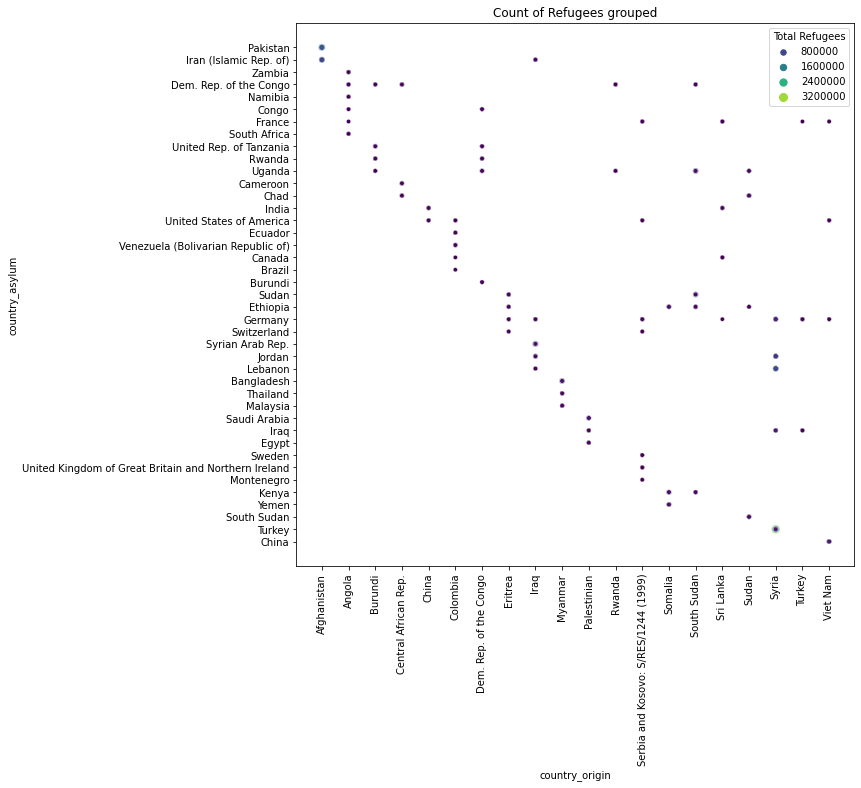

In [3]:
# Visualize the result
plt.figure(figsize=(10, 10))
sns.scatterplot(data=final_df, x='country_origin', y='country_asylum', hue='total', size='total', palette='viridis', alpha=1)
plt.legend(title='Total Refugees', loc='upper right')
plt.title('Count of Refugees grouped')
plt.xticks(rotation=90)

In [4]:
# Define the features and target variable
X = final_df.drop(['country_asylum'], axis=1)
y = final_df['country_asylum']

# Define the columns to encode
cat_features = ['country_origin']

# Create a ColumnTransformer object to apply the encoder
preprocessor = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), cat_features)])

# Apply the preprocessor to the data
X_processed = preprocessor.fit_transform(X)

# Create a LabelEncoder for country_asylum
le = LabelEncoder()

# Fit and transform the country_asylum column in y
y_processed = le.fit_transform(y)

In [5]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.3, random_state=42)

# Define the models that will be tested
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    }

#set the paremeters for each model

params = {
    'Decision Tree': {'max_depth': [None, 10, 20]},
    'Random Forest': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}
}

# Test models and parameters using GridSearchCV
for name, model in models.items():
    print(f'Testing {name}:')
    for param_name, param_values in params[name].items():
        print(f'  {param_name}: {param_values}')
        clf = GridSearchCV(model, {param_name: param_values}, scoring='accuracy', cv=10)
        clf.fit(X_train, y_train)
        print(f'  Best parameters: {clf.best_params_}')
        print(f'  Best score: {clf.best_score_:.3f}')
    print()

# Choose the best model and parameters based on the cross-validation results
best_model_name = ''
best_model = None
best_score = 0.0

for name, model in models.items():
    clf = GridSearchCV(model, params[name], scoring='accuracy', cv=10)
    clf.fit(X_train, y_train)
    if clf.best_score_ > best_score:
        best_score = clf.best_score_
        best_model = clf.best_estimator_
        best_model_name = name

print(f'The best model is {best_model_name} with an accuracy score of {best_score:.3f}')

# Train the best model on the full training set and evaluate it on the test set
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print('Classification Report:')
print(classification_report(y_test, y_pred, zero_division=1))


Testing Decision Tree:
  max_depth: [None, 10, 20]
  Best parameters: {'max_depth': None}
  Best score: 0.429

Testing Random Forest:
  n_estimators: [10, 50, 100]
  Best parameters: {'n_estimators': 50}
  Best score: 0.427
  max_depth: [None, 10, 20]
  Best parameters: {'max_depth': None}
  Best score: 0.423

The best model is Decision Tree with an accuracy score of 0.429
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         5
           1       1.00      0.00      0.00         1
           3       0.23      1.00      0.38         3
           4       1.00      0.00      0.00         1
           5       0.47      0.50      0.48        14
           6       0.42      1.00      0.59         5
           7       1.00      0.00      0.00         4
           8       0.12      0.13      0.12        15
           9       1.00      0.00      0.00         5
          10       0.50      1.00      0.67         4
      

In [8]:
# Save the best trained model. 
joblib.dump(best_model, f'Resources/{best_model_name.lower().replace(" ", "_")}_model.pkl')

# save the processor and LabelEncoder needed for Flask
joblib.dump(preprocessor, "Resources/preprocessor.pkl")
joblib.dump(le, "Resources/label_encoder.pkl")

['Resources/label_encoder.pkl']

In [10]:
# Load the trained model
dt_classifier = joblib.load(f'Resources/{best_model_name.lower().replace(" ", "_")}_model.pkl')

X = final_df.drop(['country_asylum'], axis=1)

# Make predictions for each country of origin
for country in final_df['country_origin'].unique():
    # Filter the DataFrame for the current country
    X_country = X[X['country_origin'] == country]
    
    # Apply the preprocessor to the data
    X_country_processed = preprocessor.transform(X_country)
    
    # Make a prediction for the current country
    y_pred = dt_classifier.predict(X_country_processed)
    
    # Convert the predicted label back to the original country name
    y_pred_country = le.inverse_transform([y_pred[0]])
    
    # Print the prediction for the current country
    print(f'Prediction for {country}: {y_pred_country[0]}')

Prediction for Afghanistan: Pakistan
Prediction for Angola: Dem. Rep. of the Congo
Prediction for Burundi: United Rep. of Tanzania
Prediction for Central African Rep.: Cameroon
Prediction for China: India
Prediction for Colombia: Venezuela (Bolivarian Republic of)
Prediction for Dem. Rep. of the Congo: Uganda
Prediction for Eritrea: Sudan
Prediction for Iraq: Germany
Prediction for Myanmar: Thailand
Prediction for Palestinian: Egypt
Prediction for Rwanda: Uganda
Prediction for Serbia and Kosovo: S/RES/1244 (1999): United Kingdom of Great Britain and Northern Ireland
Prediction for Somalia: Kenya
Prediction for South Sudan: Ethiopia
Prediction for Sri Lanka: India
Prediction for Sudan: Chad
Prediction for Syria: Jordan
Prediction for Turkey: Germany
Prediction for Viet Nam: China
